# Understanding Brain Tumor Classification: An Educational Journey

Welcome to this interactive notebook! Today, we're not just running code; we're going to look inside the "brain" of an Artificial Intelligence (AI) model.

## What are we doing?
We have trained a powerful AI model (ResNet18) to look at MRI scans of the brain and detect if there is a tumor, and if so, what kind (Glioma, Meningioma, or Pituitary).

## How does it work?
We use a **Convolutional Neural Network (CNN)**. Think of it like a visual cortex:
1.  **Input**: It takes an image.
2.  **Features**: It looks for simple patterns (edges, curves) first, then combines them into complex shapes (textures, tumor boundaries).
3.  **Decision**: It uses these patterns to make a probability-based guess.

Let's dive in!

In [33]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path

# Setup device (use GPU if available for speed)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Define the classes
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

Using device: mps


## 1. The Input: How Computers See Images

To us, an image is a picture. To a computer, it's just a grid of numbers. 

We need to **preprocess** the image before giving it to the model:
1.  **Resize**: The model expects a specific size (224x224 pixels).
2.  **Normalize**: We adjust the colors (math works better with small numbers like -1 to 1).
3.  **Tensor**: We convert it into a PyTorch Tensor (a multi-dimensional matrix).

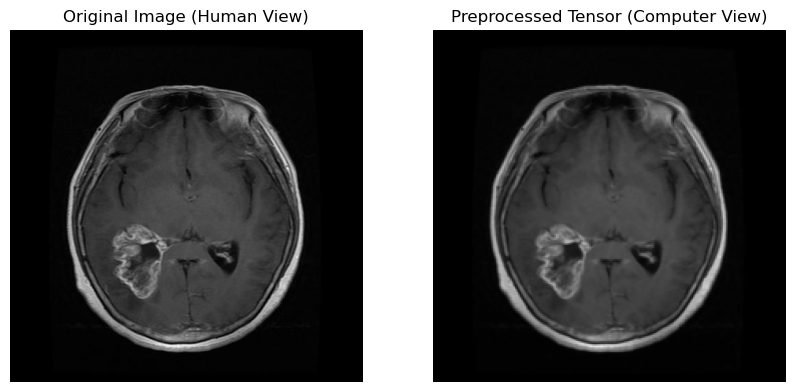

Original Size: (512, 512)
Tensor Shape: torch.Size([1, 3, 224, 224]) (Batch, Channels, Height, Width)


In [34]:
# Define the preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Standard normalization for pre-trained models
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Helper function to load and show images
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

# Find a sample image (let's look for a Glioma)
base_dir = Path("../data/Brain_Tumor_Dataset/Training/glioma")
# Get the first image found
sample_image_path = next(base_dir.glob("*.jpg"))

original_image = load_image(sample_image_path)
processed_tensor = preprocess(original_image).unsqueeze(0).to(device)

# Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image (Human View)")
plt.axis('off')

plt.subplot(1, 2, 2)
# We need to undo normalization to show the tensor as an image again
tensor_view = processed_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
tensor_view = (tensor_view * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
tensor_view = np.clip(tensor_view, 0, 1)

plt.imshow(tensor_view)
plt.title("Preprocessed Tensor (Computer View)")
plt.axis('off')

plt.show()

print(f"Original Size: {original_image.size}")
print(f"Tensor Shape: {processed_tensor.shape} (Batch, Channels, Height, Width)")

## 2. The Brain: Loading the Model

We will load our trained **ResNet18** model. This model has learned from thousands of brain scans.

In [35]:
# Load the model architecture
model = models.resnet18(weights=None)
# Recreate the classifier head exactly as it was during training
# The saved model has 'fc.1.weight', implying a Sequential block with Dropout
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, len(class_names))
)

# Load the trained weights
# Try to find the best available model
possible_models = [
    "../models/brain_tumor_resnet18_v2.pt",
    "../models/brain_tumor_resnet18_final.pt",
    "../models/brain_tumor_resnet18.pt"
]

model_path = None
for path in possible_models:
    if os.path.exists(path):
        model_path = path
        break

if model_path is None:
    raise FileNotFoundError("Could not find any trained ResNet18 model in ../models/")

print(f"Loading model from: {model_path}")
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
except RuntimeError as e:
    print(f"Error loading model: {e}")
    print("Attempting to load with strict=False (ignoring non-matching keys)...")
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

model = model.to(device)
model.eval() # Set to evaluation mode

print("Model loaded successfully!")

Loading model from: ../models/brain_tumor_resnet18_v2.pt
Model loaded successfully!


### 2.1 Visualizing the Architecture
Let's see what layers are inside ResNet18. It's made of many "Convolutional" blocks.

In [36]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 2.2 What does the model "see" first?
The very first layer (`conv1`) looks for simple shapes like lines and edges. Let's visualize its filters (kernels).

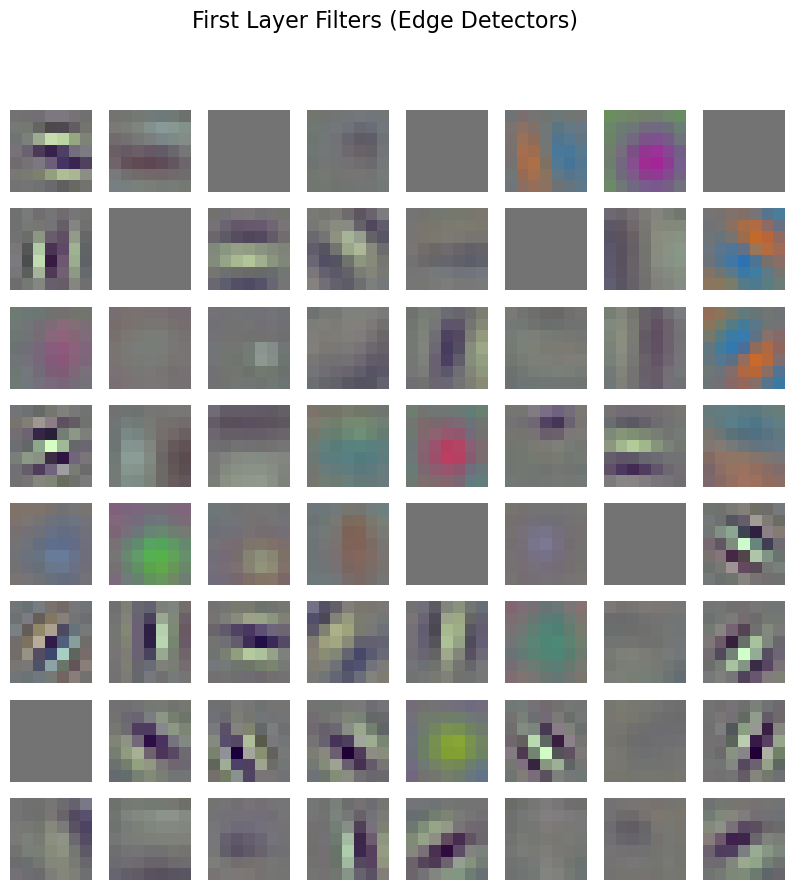

In [37]:
# Get the weights of the first layer
filters = model.conv1.weight.data.cpu().clone()
# Normalize for visualization (0 to 1)
filters = filters - filters.min()
filters = filters / filters.max()

plt.figure(figsize=(10, 10))
for i in range(64): # ResNet18 has 64 filters in the first layer
    plt.subplot(8, 8, i+1)
    # Filters are 7x7x3 (RGB), we permute to (7, 7, 3) for matplotlib
    plt.imshow(filters[i].permute(1, 2, 0))
    plt.axis('off')
plt.suptitle("First Layer Filters (Edge Detectors)", fontsize=16)
plt.show()

## 3. Feature Maps: The Model's Vision
As the image passes through the layers, it gets transformed. These transformed images are called **Feature Maps**.

1.  **Early layers**: Preserve the shape of the brain.
2.  **Deep layers**: Look abstract and blurry (focusing on "concepts" like tumor texture rather than exact pixels).

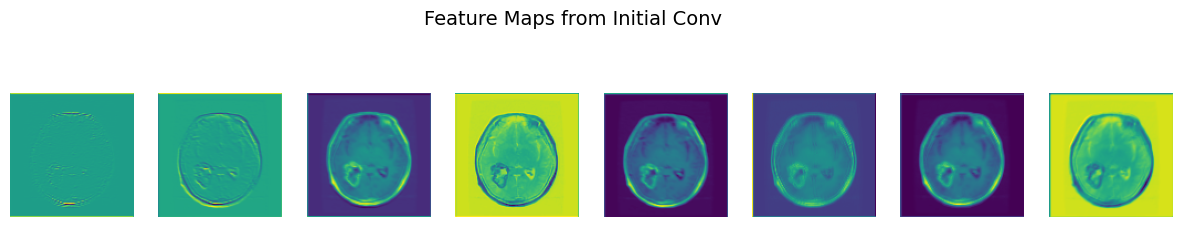

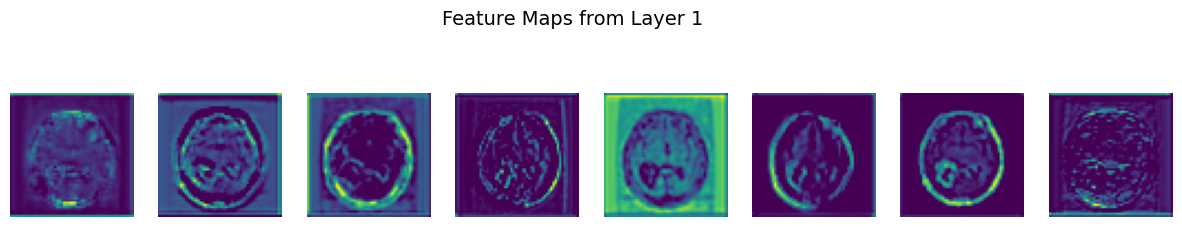

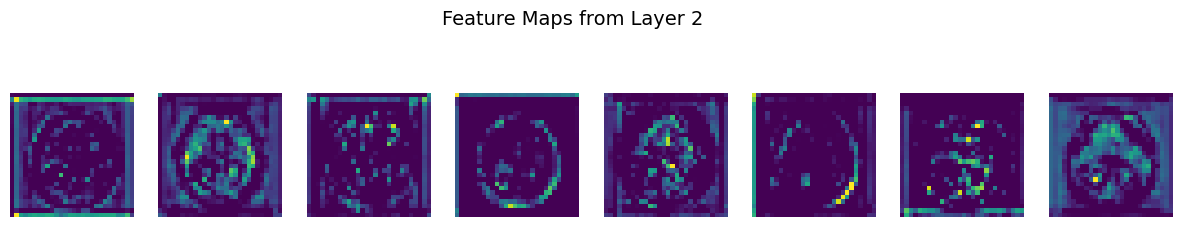

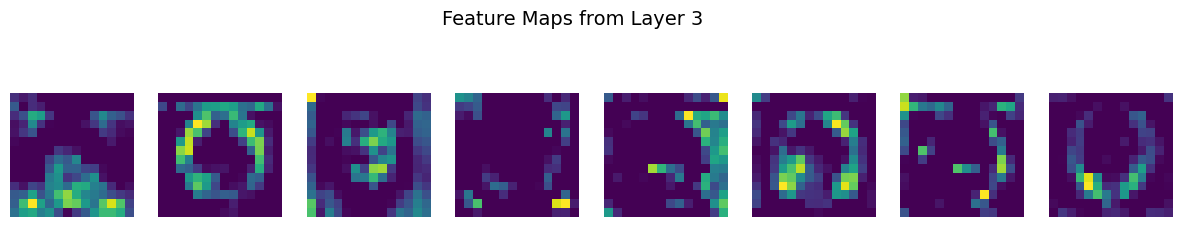

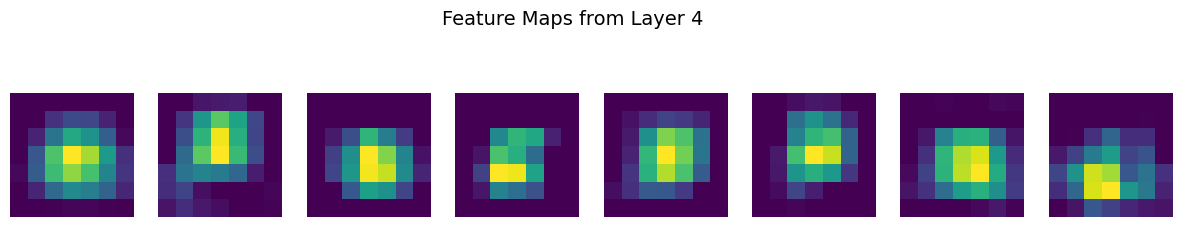

In [38]:
# Hook function to capture feature maps
feature_maps = []
def hook_fn(module, input, output):
    feature_maps.append(output)

# Register hooks on interesting layers
layers_to_hook = [model.conv1, model.layer1, model.layer2, model.layer3, model.layer4]
hooks = [layer.register_forward_hook(hook_fn) for layer in layers_to_hook]

# Pass the image through the model
with torch.no_grad():
    model(processed_tensor)

# Remove hooks
for hook in hooks:
    hook.remove()

# Visualize Feature Maps from different depths
layer_names = ['Initial Conv', 'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4']

for layer_idx, fmap in enumerate(feature_maps):
    plt.figure(figsize=(15, 3))
    # Show the first 8 channels of the feature map
    for i in range(8):
        plt.subplot(1, 8, i+1)
        fm = fmap[0, i].cpu().numpy()
        plt.imshow(fm, cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature Maps from {layer_names[layer_idx]}", fontsize=14)
    plt.show()

## 4. The Decision: How does it choose?
The model outputs a score for each of the 4 classes. We turn these scores into probabilities (percentages).

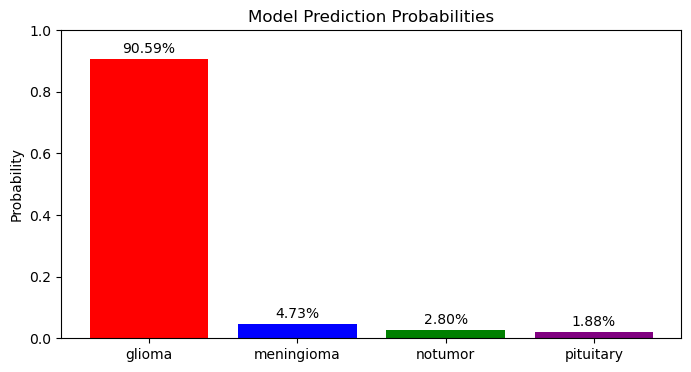

The model predicts: glioma


In [39]:
# Get the model output
with torch.no_grad():
    output = model(processed_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]

# Plot the probabilities
probs = probabilities.cpu().numpy()
plt.figure(figsize=(8, 4))
plt.bar(class_names, probs, color=['red', 'blue', 'green', 'purple'])
plt.title("Model Prediction Probabilities")
plt.ylabel("Probability")
plt.ylim(0, 1)
for i, v in enumerate(probs):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')
plt.show()

predicted_class = class_names[np.argmax(probs)]
print(f"The model predicts: {predicted_class}")

## 5. Explainability: Why did it choose that?
We use a technique called **Grad-CAM** (Gradient-weighted Class Activation Mapping). It highlights the parts of the image that were most important for the decision.

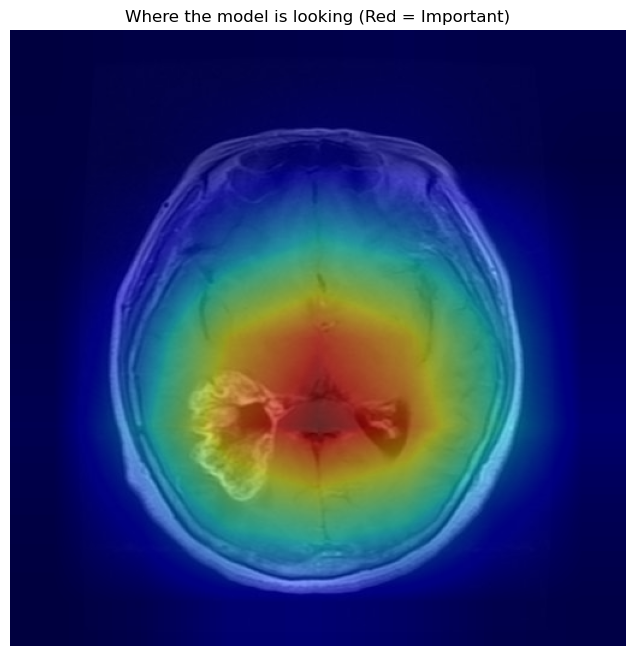

In [40]:
# Simple Grad-CAM implementation
def generate_gradcam(model, input_tensor, target_size=(224, 224)):
    # Hook to capture gradients and activations
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks on the last convolutional layer (layer4)
    target_layer = model.layer4[-1]
    hook_b = target_layer.register_full_backward_hook(backward_hook)
    hook_f = target_layer.register_forward_hook(forward_hook)

    # Forward pass
    model.eval()
    output = model(input_tensor)

    # Backward pass for the predicted class
    model.zero_grad()
    target_class = output.argmax()
    output[0, target_class].backward()

    # Remove hooks
    hook_b.remove()
    hook_f.remove()

    # Get gradients and activations
    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]

    # Calculate weights (global average pooling of gradients)
    weights = np.mean(grads, axis=(1, 2))

    # Weighted combination of feature maps
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]

    # ReLU (we only care about positive influence)
    cam = np.maximum(cam, 0)

    # Resize to image size
    cam = cv2.resize(cam, target_size)

    # Normalize
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

# Generate heatmap
target_size = original_image.size
heatmap = generate_gradcam(model, processed_tensor, target_size=target_size)

# Overlay on original image
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.imshow(heatmap, cmap='jet', alpha=0.5) # Alpha controls transparency
plt.title(f"Where the model is looking (Red = Important)")
plt.axis('off')
plt.show()

## 6. How does it learn? (The Training Loop)
The model didn't know this from the start. It learned by trial and error.

1.  **Forward Pass**: Make a guess.
2.  **Loss Calculation**: Compare guess to reality (e.g., "I said Glioma, but it was Meningioma").
3.  **Backward Pass (Backprop)**: Calculate how to adjust the "neurons" to reduce the error.
4.  **Optimizer**: Make the adjustment.

Here is a simulation of one training step:

In [41]:
# Dummy training step
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. Forward
output = model(processed_tensor)

# 2. Loss (Assume the true label was 0: Glioma)
true_label = torch.tensor([0]).to(device)
loss = criterion(output, true_label)
print(f"Error (Loss): {loss.item():.4f}")

# 3. Backward
optimizer.zero_grad()
loss.backward()
print("Gradients calculated (The model knows how to fix itself)")

# 4. Optimizer Step
optimizer.step()
print("Weights updated (The model is slightly smarter now)")

Error (Loss): 0.0988
Gradients calculated (The model knows how to fix itself)
Weights updated (The model is slightly smarter now)


In [42]:
# Visualize Network Architecture
print("Model Architecture:")
# print(model) # Commented out to save space, uncomment if needed

print("\nModel Graph (torch.fx):")
try:
    import torch.fx
    # Symbolic tracing can be tricky with complex models, wrapping in try-except
    gm = torch.fx.symbolic_trace(model)
    gm.graph.print_tabular()
except Exception as e:
    print(f"Could not generate torch.fx graph: {e}")

# Generate Mermaid.js Graph and Render as Image
import base64
from IPython.display import Image, display

def get_mermaid_graph(model, input_shape=(1, 3, 224, 224)):
    graph = ["graph TD"]
    # Quote the label to handle parentheses in input_shape
    graph.append(f"    Input(\"Input {input_shape}\")")
    previous_node = "Input"

    try:
        for name, layer in model.named_children():
            # Sanitize name for Mermaid ID (remove dots, spaces, special chars)
            node_id = name.replace(".", "_").replace(" ", "_").replace("-", "_")
            layer_type = layer.__class__.__name__

            # Use sanitized ID, but keep original name in label
            graph.append(f"    {node_id}[\"{name}<br/>{layer_type}\"]")
            graph.append(f"    {previous_node} --> {node_id}")
            previous_node = node_id
    except Exception as e:
        print(f"Error generating graph nodes: {e}")
        return None

    graph.append(f"    {previous_node} --> Output")
    return "\n".join(graph)

try:
    mermaid_code = get_mermaid_graph(model)
    if mermaid_code:
        # Encode for mermaid.ink
        graphbytes = mermaid_code.encode("utf8")
        base64_bytes = base64.b64encode(graphbytes)
        base64_string = base64_bytes.decode("ascii")
        url = "https://mermaid.ink/img/" + base64_string

        print("Model Architecture Visualization:")
        display(Image(url=url))
    else:
        print("Could not generate Mermaid graph.")
except Exception as e:
    print(f"Visualization failed: {e}")

Model Architecture:

Model Graph (torch.fx):
opcode         name                   target                                                   args                                   kwargs
-------------  ---------------------  -------------------------------------------------------  -------------------------------------  --------
placeholder    x                      x                                                        ()                                     {}
call_module    conv1                  conv1                                                    (x,)                                   {}
call_module    bn1                    bn1                                                      (conv1,)                               {}
call_module    relu                   relu                                                     (bn1,)                                 {}
call_module    maxpool                maxpool                                                  (relu,)                     

# Summary: What Have We Learned?

Congratulations on completing this journey into the "brain" of an AI! Let's recap our key takeaways:

1.  **Images are Numbers**: To a computer, an MRI scan is just a tensor—a grid of numbers representing pixel intensities.
2.  **Layers of Abstraction**: Convolutional Neural Networks (CNNs) like ResNet18 process these numbers through layers. Early layers find simple edges, while deeper layers find complex patterns like tumor shapes.
3.  **Explainability Matters**: Tools like **Grad-CAM** allow us to peek inside the black box. By visualizing which parts of the image the model focuses on, we can verify if it's looking at the tumor or getting distracted by the background.
4.  **Architecture Visualization**: We saw the flow of data from input to output, passing through various blocks of the network.

## Visual Recap

Here are some placeholders for the concepts we covered. 

### 1. Input Tensor
*(Placeholder: Image showing a grid of pixel values)*

### 2. Feature Maps
*(Placeholder: Image showing activations of early vs. late layers)*

### 3. Grad-CAM Heatmap
*(Placeholder: The heatmap overlay we generated above)*

AI is not magic; it's a powerful tool built on math and data. Understanding how it works empowers us to build better, safer, and more reliable systems for healthcare and beyond.